# Face classification

## Data analysis:
- 100000 image and 100000 labels.
- Data are 3-channel RGB images
- Imbalanced dataset ~15%
- Visually cannot relate class to features in the image
- HTER is a trade-off between specificity and sensitivity

## Hypothesis after Data Analysis:
- Dataset has only different faces (no redundancy of the same persons)
- Resampling strategies will have an effect on the final HTER
- Shallow model will fail extracting the proper features. 
- Deeper model will extract more complex features to be able to classify data

In [2]:
import os, glob, sys
from tqdm import tqdm
import time
import math

import numpy as np
import matplotlib.pyplot as plt 

from PIL import Image
import cv2

import pandas as pd
import yaml

from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score

from preprocessing import load_and_normalize_images, read_label
from preprocessing import get_sample


In [23]:
path_training = 'train_img'
path_val = 'val_img'
label_file = 'label_train.txt'
path_best_model = r"run\log_2024_09_05_09_58_45_epochs_100_lr_0.001_batch_size_128_model_base_mode_Val_method_None\best_model.keras"
path_yaml_experiment_tracking = r"run\log_2024_09_04_19_39_57_epochs_100_lr_0.001_batch_size_128_model_small_model_mode_Val_method_None\experiment_tracking.yaml"

# Experiment tracking

For each test of parameters, experiment_tracking file are produced to track the evolution of the performances in regards with input arguments.

In [14]:
def load_experiment_data(yaml_file_path:str):
    """
    Display parameters, arguments and performances

    Parameters:
        yaml_file_path (str): Path to yaml data
        
    Returns:
        Dict : experiment_data storing the parameters, arguments and performances
    """
    with open(yaml_file_path, 'r') as file:
        experiment_data = yaml.load(file, Loader=yaml.FullLoader)
    return experiment_data

# Read the experiment data to track parameters and performances
yaml_file_path = path_yaml_experiment_tracking
experiment_data = load_experiment_data(yaml_file_path)

arguments = experiment_data['arguments']
parameters = experiment_data['parameters']
performance = experiment_data['performance']


print("Arguments:", arguments)
print("Parameters:", parameters)
print("Performance:", performance)


Arguments: {'batch_size': 128, 'epoch_interval': 5, 'epochs': 100, 'image_path': 'train_img', 'label_path': 'label_train.txt', 'lr': 0.001, 'method': 'None', 'oversampling': 0.1, 'training_mode': 'Val', 'undersampling': None}
Parameters: {'run': 'log_2024_09_04_19_39_57'}
Performance: {'HTER_train': '0.115755', 'HTER_val': '0.130937', 'f1_train': '0.938562', 'f1_val': '0.934223', 'roc_auc_train': '0.884245', 'roc_auc_val': '0.869063'}


In [15]:
normalized_images = load_and_normalize_images(path_training)
y = read_label(label_file)
X = normalized_images 

100%|██████████| 100000/100000 [01:08<00:00, 1458.77it/s]






############################ PREPROCESSING ############################ 
Label du fichier label_train.txt
   label
0      1
1      1
2      1
3      1
4      1


Nombre de valeurs dans le df len(100000)- verification pas d'outlier
label    2
dtype: int64


Nombre d'occurences de chaque label
label
1        87898
0        12102
Name: count, dtype: int64




### Display

Text(0.5, 1.0, 'Image n°579 - label: [1.]')

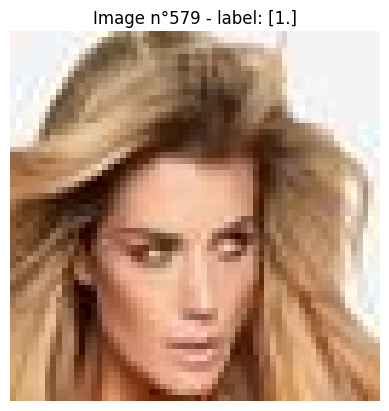

In [16]:
num_image = np.random.choice(len(normalized_images))
show_image_title = y[num_image]
show_image = normalized_images[num_image]

plt.imshow(show_image)
plt.axis('off')
plt.title(f'Image n°{num_image} - label: {show_image_title}')

### Display images with label 0 & label 1

In [18]:
images_0,images_1 = [], []
label_0,label_1 = [], []

# Loop through the sorted labels and images and separate them based on the label
for label, image in zip(y, normalized_images):
    if label == 0:
        images_0.append(image)
        label_0.append(label)

    else:
        images_1.append(image)
        label_1.append(label)
images_0 = np.asarray(images_0)
label_0 = np.asarray(label_0)
images_1 = np.asarray(images_1)
label_1 = np.asarray(label_1)


In [17]:
import time
import math
def get_sample_prediction(  image_set: np.ndarray,
                            labels: np.ndarray,
                            prediction: np.ndarray,
                            n_draw: int,
                            flag_display=False,
                            ):
    """
    Display random samples with labels in a grid.

    Parameters:
        image_set (np.ndarray): A NumPy array of images.
        labels (np.ndarray): A NumPy array of labels.
        n_draw (int): Number of samples to draw randomly from image set
        flag_display (Boolean): Set to True to plot the figures
        
    Returns:
        np.ndarray: A NumPy array of indices of drawn images.
    """
    # Select n_draw random images and corresponding labels from the set
    indices = np.random.choice(len(image_set), size=n_draw, replace=False)
    sample_images = image_set[indices]
    sample_labels = labels[indices]
    sample_predicted = prediction[indices]

    combined = list(zip(sample_labels, sample_images, sample_predicted))
    sorted_combined = sorted(combined, key=lambda x: x[0])
    sorted_labels, sorted_normalized_image , sorted_sample_predicted = zip(*sorted_combined)

    sorted_labels = list(sorted_labels)
    sorted_normalized_image = list(sorted_normalized_image)

    if flag_display == True:
        # Grid parameters
        cols = int(math.ceil(math.sqrt(n_draw)))
        rows = int(math.ceil(n_draw / cols))
        
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 2.5))
        
        for i, ax in enumerate(axes.flatten()):
            if i < n_draw:
                ax.imshow(sorted_normalized_image[i])
                ax.axis('off')
                ax.set_title(f"Label: {sorted_labels[i]} - Pred {sorted_sample_predicted[i]}")
            else:
                ax.axis('off')  

        plt.tight_layout()
        plt.show()
        
        # Wait for 2 seconds
        time.sleep(2)
        
        # Close the figure
        plt.close(fig)


In [ ]:
# Plot images and associated labels per class

n_draw = 100
get_sample(images_0, label_0, n_draw=n_draw, flag_display=True)
get_sample(images_1, label_1, n_draw=n_draw, flag_display=True)

# Test for the best HTER

625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step


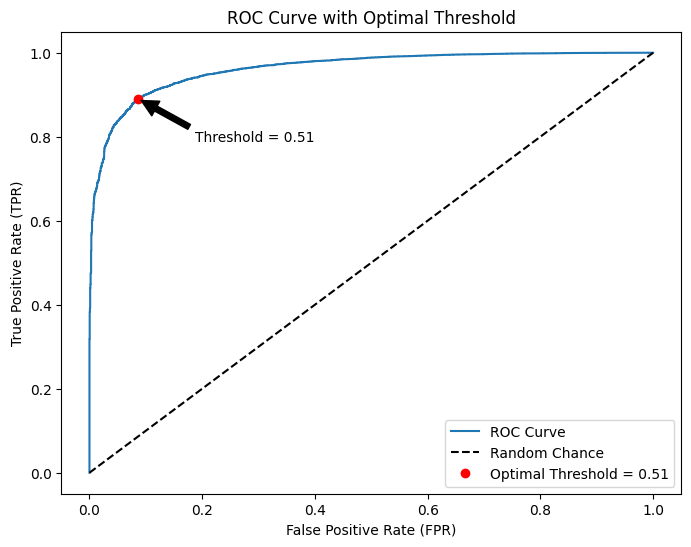

In [26]:
# Roc curve: TPR sensitivity vs FPR non-specificity
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
best_model = load_model(path_best_model)
y_pred_prob_test = best_model.predict(x_val)

fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob_test)

J = tpr - fpr
optimal_idx = np.argmax(J)
optimal_threshold = thresholds[optimal_idx]

optimal_fpr = fpr[optimal_idx]
optimal_tpr = tpr[optimal_idx]


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.plot(optimal_fpr, optimal_tpr, 'ro', label=f'Optimal Threshold = {optimal_threshold:.2f}')
plt.annotate(f'Threshold = {optimal_threshold:.2f}', 
             xy=(optimal_fpr, optimal_tpr), 
             xytext=(optimal_fpr + 0.1, optimal_tpr - 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve with Optimal Threshold')
plt.legend(loc='best')
plt.show()

In [27]:
# It seems to have learned to classify glasses
best_model = load_model(path_best_model)
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
y_pred_prob_test = best_model.predict(x_val)

threshold = 0.5 # Initially 
threshold = optimal_threshold
y_pred_test= (y_pred_prob_test > threshold).astype(int)

# For loop to store images, labels and predictions depending on their label
images_0,images_1 = [], []
label_0,label_1 = [], []
pred_0, pred_1 = [], []

# Loop through the sorted labels and images and separate them based on the label
for label, image, pred in zip(y_val, x_val, y_pred_test):
    if label == 0:
        images_0.append(image)
        label_0.append(label)
        pred_0.append(pred)

    else:
        images_1.append(image)
        label_1.append(label)
        pred_1.append(pred)

images_0 = np.asarray(images_0)
label_0 = np.asarray(label_0)
pred_0 = np.asarray(pred_0)
images_1 = np.asarray(images_1)
label_1 = np.asarray(label_1)
pred_1 = np.asarray(pred_1)

625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 59ms/step


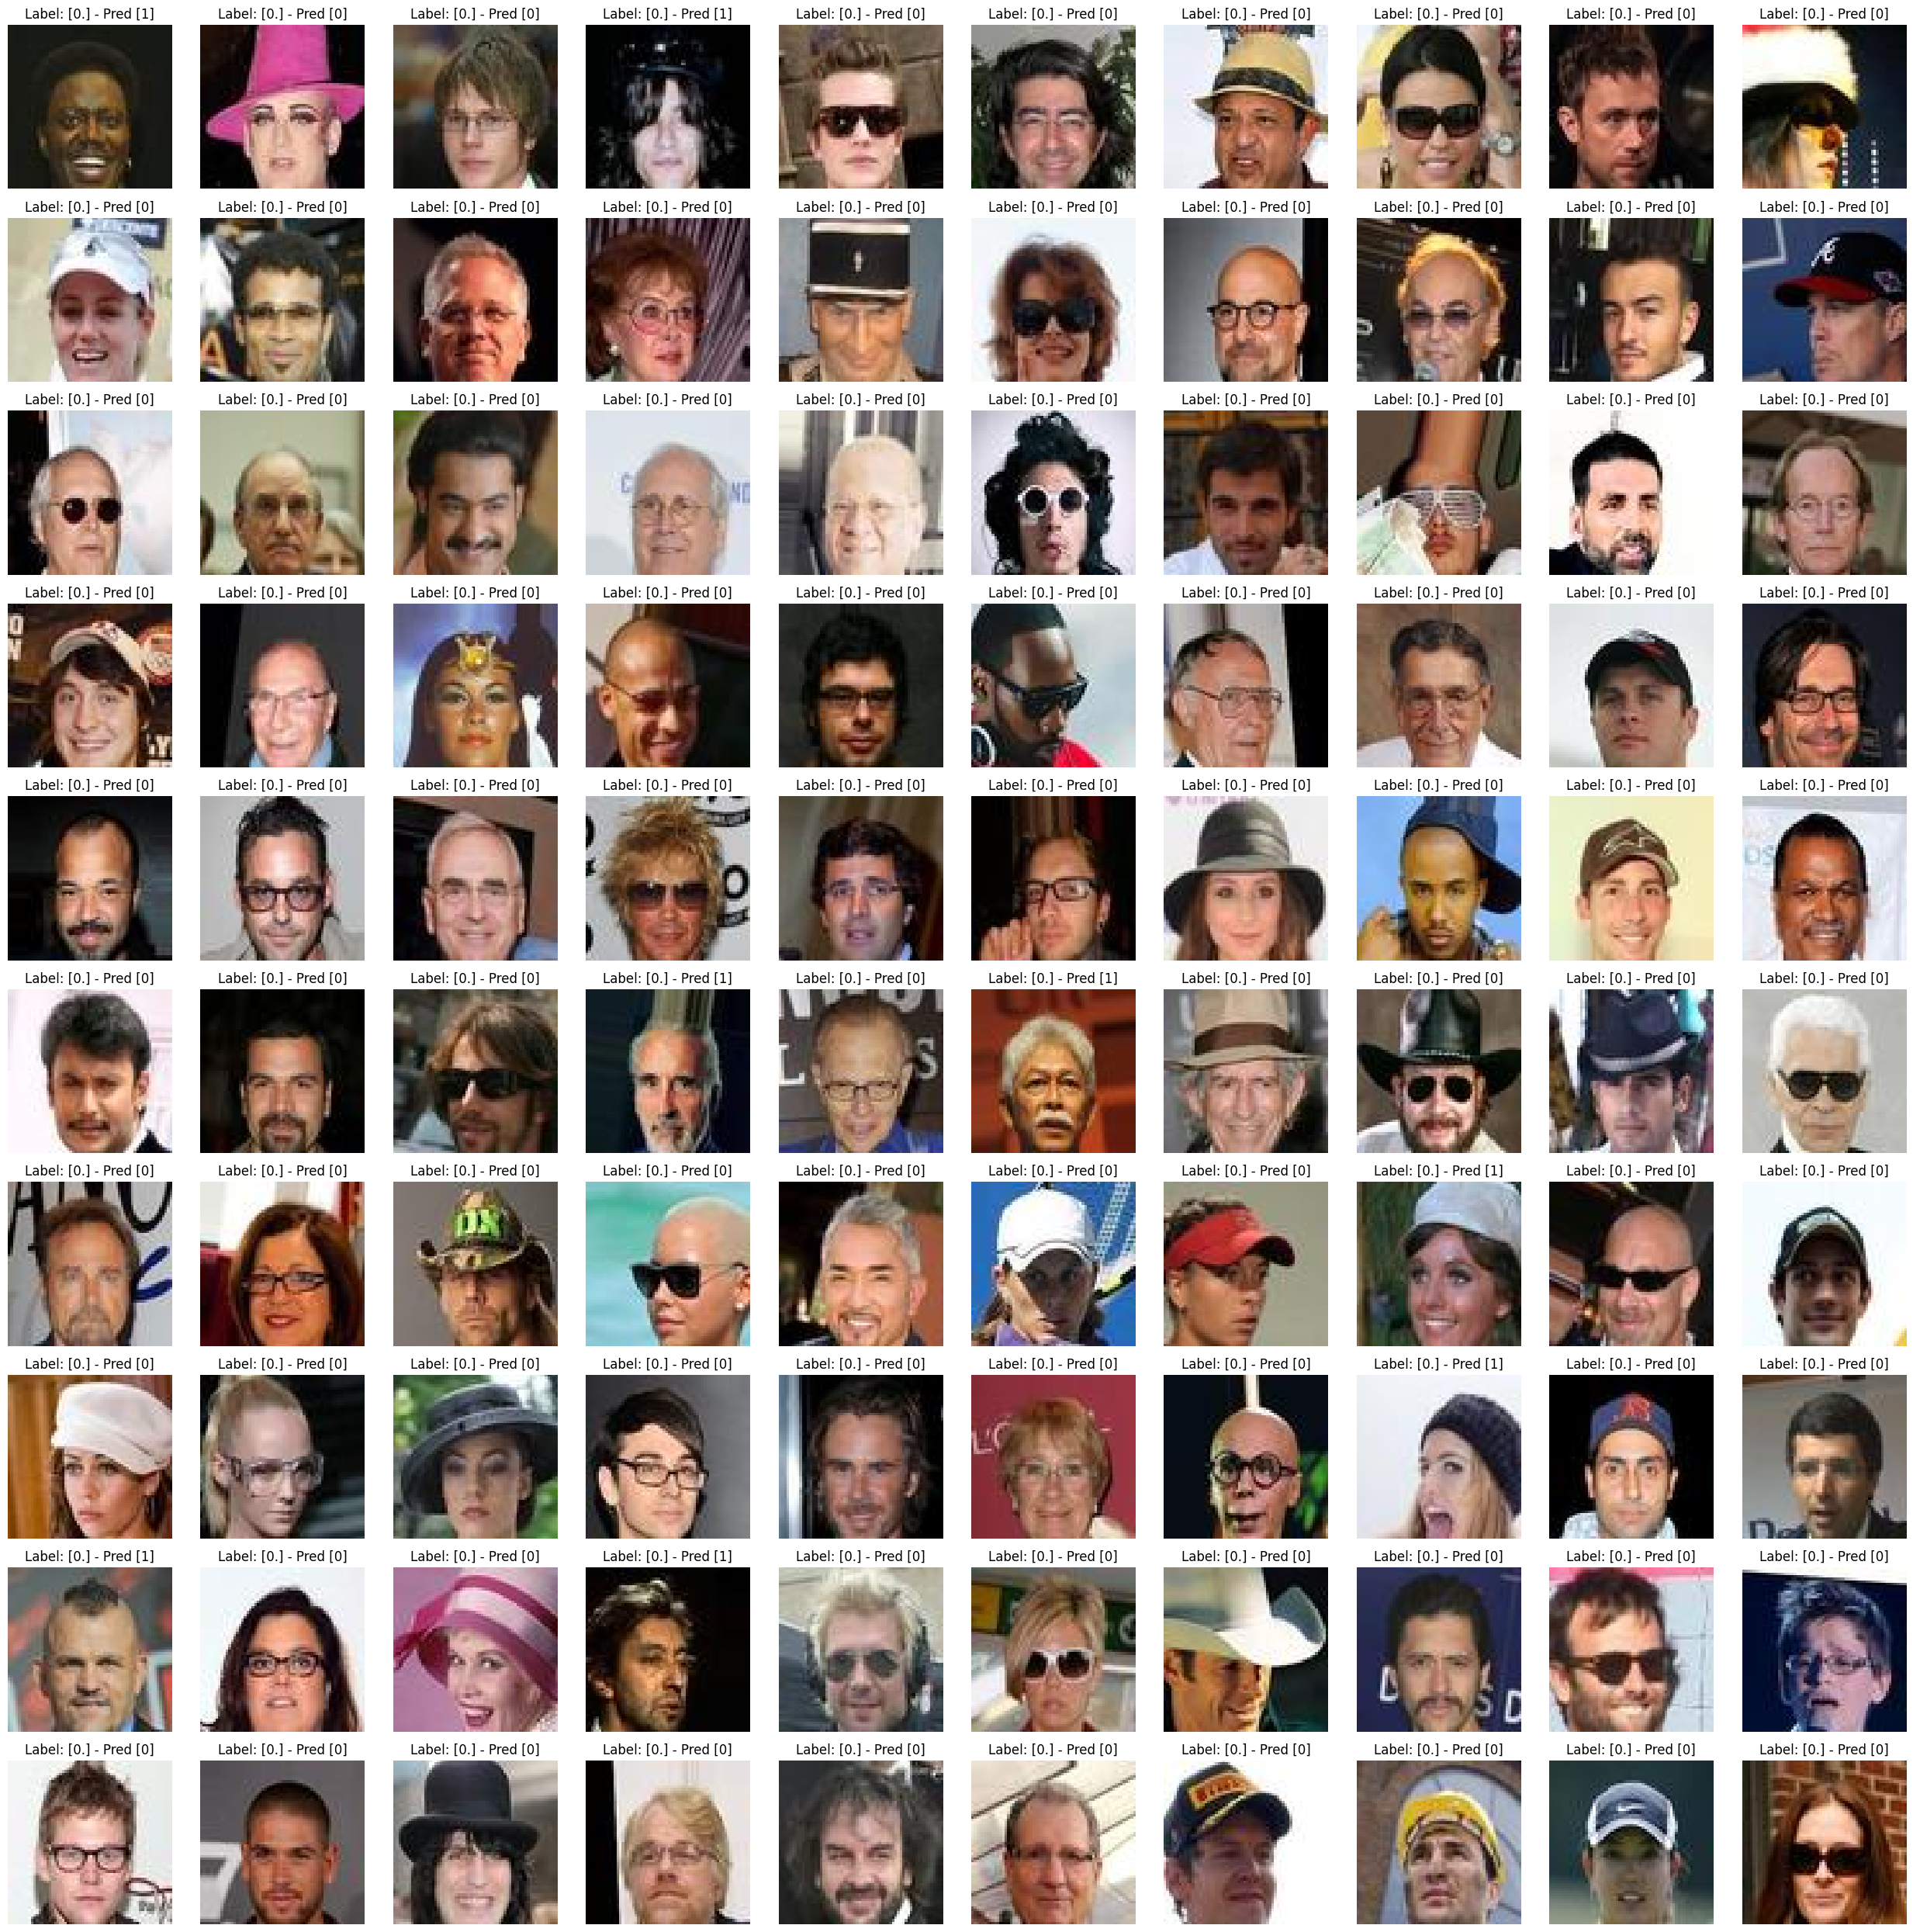

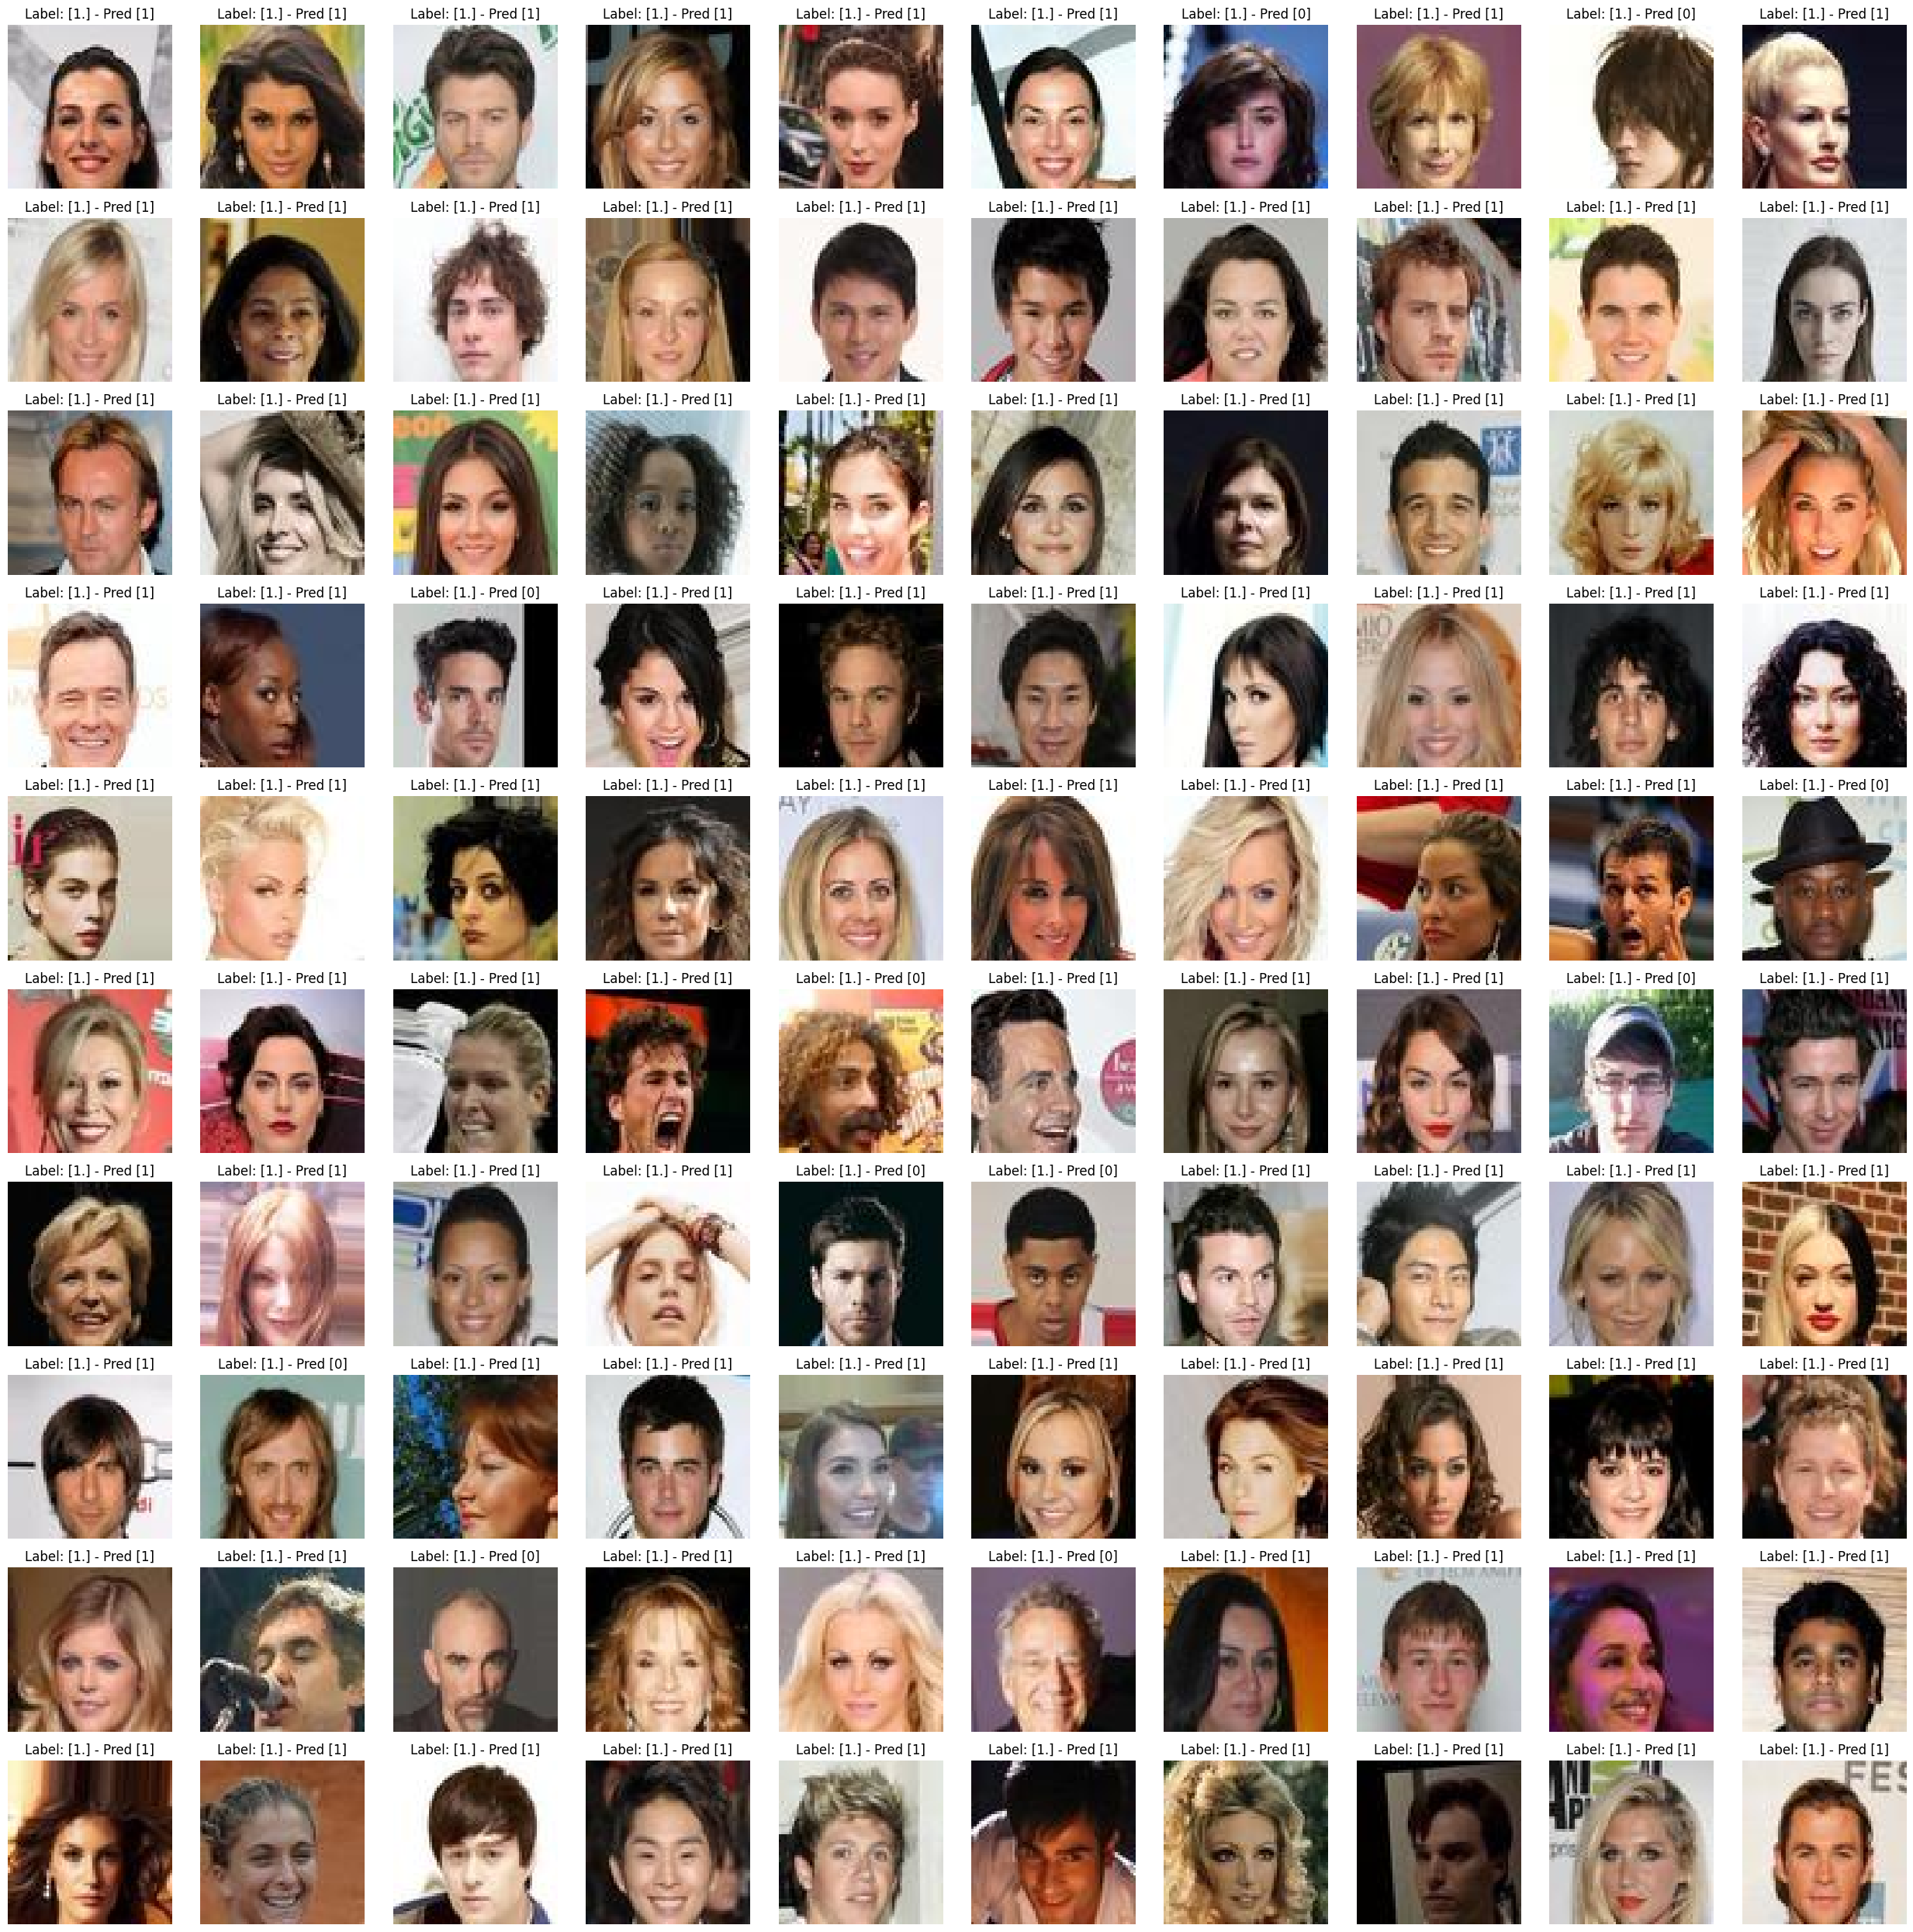

In [28]:
get_sample_prediction(images_0, label_0, pred_0, n_draw=n_draw, flag_display=True)
get_sample_prediction(images_1, label_1, pred_1, n_draw=n_draw, flag_display=True)

# Predictions on unseen data - output.csv

In [29]:
image_directory = path_val
normalized_images = load_and_normalize_images(image_directory)
best_model = load_model(path_best_model)
y_pred_prob_test = best_model.predict(normalized_images)

# set the threshold to the value which outputs the optimal HTER (determined with ROC curve)
threshold=optimal_idx
y_pred_test = (y_pred_prob_test > threshold).astype(int)


100%|██████████| 20000/20000 [00:15<00:00, 1309.41it/s]


625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 54ms/step


In [30]:
np.savetxt("val_img/output.csv", y_pred_test, delimiter=",", header="Predicted Label", comments='', fmt='%d')

In [31]:
def label_predictions(image_set: np.ndarray,
                       predicted_label: np.ndarray,
                       ):
    """
    Display random samples with predicted labels in a grid.

    Parameters:
        image_set (np.ndarray): A NumPy array of images.
        predicted_label (np.ndarray): A NumPy array of labels.
        n_draw (int): Number of samples to draw randomly from image set

        
    Returns:
        np.ndarray: A NumPy array of indices of drawn images.
    """
# Select 6 random images from the set
    indices = np.random.choice(len(image_set), size=6, replace=False)
    sample_images = image_set[indices]
    sample_labels = predicted_label[indices]


    
    # Create a matplotlib figure
    fig, axes = plt.subplots(2, 3, figsize=(8, 6))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(sample_images[i])
        ax.axis('off')
        ax.set_title(f"Pred: {sample_labels[i]}")
    plt.show()

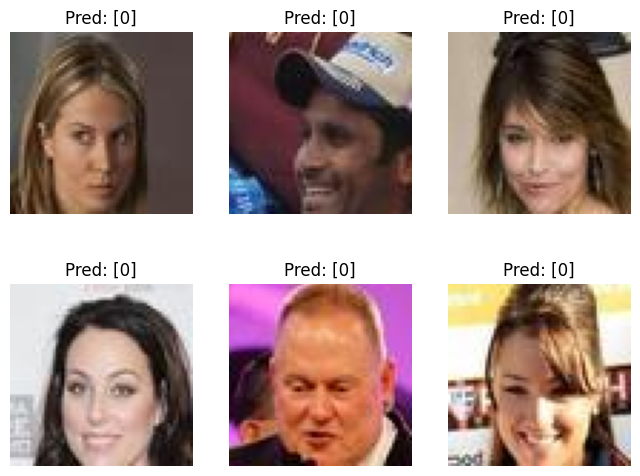

In [32]:
from tensorflow.keras.models import load_model

label_predictions(x_val, y_pred_test)